In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>03.10.2022</center>


## Plan

1. Latent Variable Modeling

    - Gaussian Mixture Models (GMM)
    
    - Principial Component Analysis (PCA) and Probabilistic PCA (pPCA) <span style="color:red"> No! </span>
    
2. ELBO and EM - algorithm. 
    
    - EM algorithm for GMM (theory and practice)
    
    - EM algorithm for probabilistic PCA (theory) <span style="color:red"> No! </span>

3. VAE
    
    - VAE on 2D data (practice)
    

## Latent Variables Model

<center><img src="pics/lvm_diagram.png" width=600 /></center>

**Advantages**

1. Latent space could describe high-level features of the data:

<center><img src="pics/celeba_interpolation.png" width=300 /></center>

2. the distributions $p(x | z)$ and $p(z)$ could be rather simple:
    
    * Example: $p(x|z) = \mathcal{N}(\boldsymbol{\mu}(z), \boldsymbol{\Sigma}(z))$, $p(z) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
    
3. It is beneficial to model $p(z | x)$

<center><img src="pics/image_restoration.png" width=300 /></center>


**Likelihood**

$p(x |\theta) = \int\limits_{\mathcal{Z}} p(x | z, \theta) p(z| \theta) dz$

**Sampling procedure**

* Sample $z^* \sim p(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

### Gaussian Mixture Models

$p(z | \theta) = \text{Categorical}(\pi_1, \dots \pi_k)$

$p(\boldsymbol{x} | z, \theta) = \mathcal{N}\left(\boldsymbol{x}|, \boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z\right)$

**Likelihood** of the model?

$p(x | \theta) = \sum\limits_{i = 1}^{k}  \pi_i \mathcal{N}\left(x - \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)$

In [3]:
a = np.array([1., 2.])
torch.tensor(a)

tensor([1., 2.], dtype=torch.float64)

**Note:** Можно создавать параметры модели следующим образом!: 

```python
self.param = nn.Parameter(param)
```

Поскольку  `__setattr__` переопредлён!

In [31]:
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

In [296]:
class GMM(nn.Module):

    @property
    def sigma(self):
        return self._L @ self._L.transpose(1, 2)
    
    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    def __init__(self, k, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
        '''
        super().__init__()
        self.k = k
        self.dim = dim
        if mu is None:
            mu = np.random.rand(k, dim)*20 - 10
        self.mu = nn.Parameter(torch.tensor(mu))
        if sigma is None :
            sigma = np.zeros((k, dim, dim))
            for i in range(k):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma)
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.k)/self.k
        self.pi = torch.tensor(pi)
        # mix = TD.Categorical(self.pi)
        # mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self.sigma)
        # self.gmm = TD.MixtureSameFamily(mix, mv_normals)
        # self.gmm = TD.MultivariateNormal(self.mu, self.sigma)

    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)

    def prob(self, X):
        '''
        Compute the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        return torch.exp(self.log_prob(X))

    def sample(self, shape):
        return self.gmm.sample(shape)

    def loss(self, x):
        # self._project()
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

GMM visualization

In [297]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11), dx=0.1, dy=0.1, device=DEVICE):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

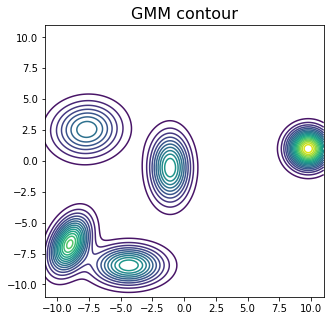

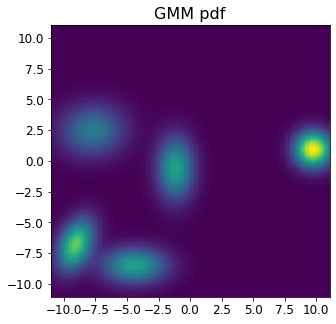

In [298]:
np.random.seed(45)
sigmas = np.array([
    [[1., 0.], [0., 1]],
    [[3., 0.], [0., 1]],
    [[1., 0.], [0., 3]],
    [[1., 0.5], [  0.5, 2.]],
    [[3., 0.1], [0.1, 2]]
])

gmm = GMM(5, 2, sigma=sigmas).to(DEVICE)
draw_distrib(gmm, 'GMM')

**Question.**

How to fit GMM model to data $X_1, \dots X_n$ from unknown distribution?

- One can try likelihood maximization

- EM algorithm (will be explained soon)

### GMM via MLE

Let $X_1, \dots, X_n \sim p(x)$ , $X_i \in \mathbb{R}^D$

**GMM** model likelihood: 

$\log p(\boldsymbol{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum\limits_{j = 1}^{n} \log \left(\sum\limits_{i = 1}^{k}  \pi_i \mathcal{N}\left(X_j - \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)\right)$

Analytical solution is **hard**!

### Task setup

The distribution we would like to learn

In [299]:
class FlowerGMM(GMM):

    def __init__(self):
        CENTERS_SCALE = 5.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...], 
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)

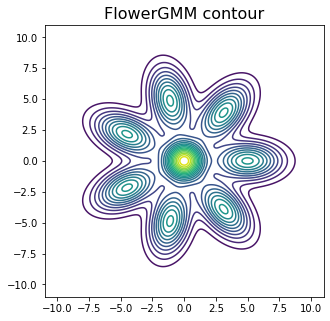

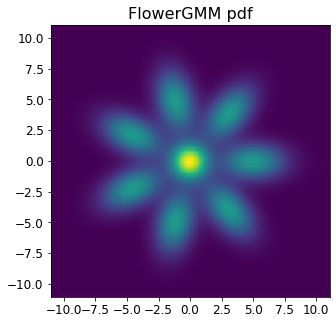

In [300]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

Reference samples from the `FlowerGMM`

In [301]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()

Initialize GMM model which will be trained

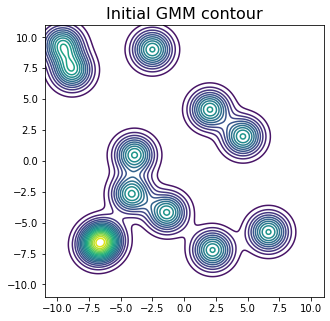

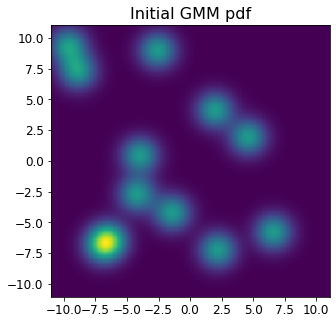

In [310]:
np.random.seed(42)
N_COMPONENTS = 12
gmm = GMM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

In [311]:
BATCH_SIZE = 128
LR= 1e-3
EPOCHS = 100
USE_CUDA=True

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    gmm, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)

  0%|          | 0/100 [00:00<?, ?it/s]

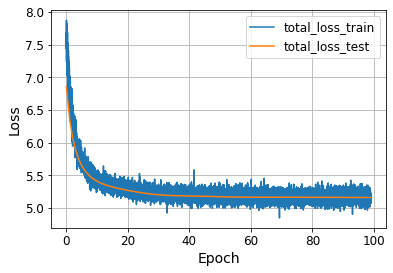

In [312]:
plot_training_curves(train_losses, test_losses)

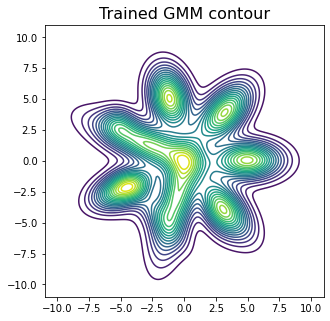

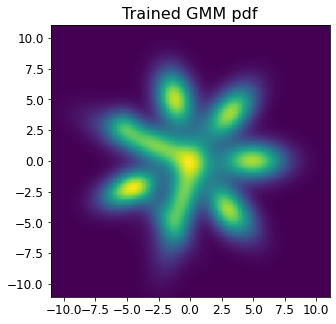

In [313]:
draw_distrib(gmm, 'Trained GMM')

### GMM via EM - algorithm

## PCA



<center><img src="pics/pca.png" width=300 /></center>

Let $X_1, \dots, X_n \in \mathbb{R}^D$

$\max\limits_{\boldsymbol{e}_1, \dots \boldsymbol{e}_d} \sum\limits_{j = 1}^{d}\left(\frac{1}{n} \sum\limits_{i = 1}^n \langle \boldsymbol{e}_j, X_i\rangle  - \langle \boldsymbol{e}_j, \overline{X}\rangle\right)$, where $\boldsymbol{e}_j \in \mathbb{R}^D\, , \, \Vert \boldsymbol{e}_j \Vert_2 = 1 \, , \, \boldsymbol{e}_j \perp \boldsymbol{e}_i$

* Original $\rightarrow$ Compressed:

    $y = \begin{bmatrix}\boldsymbol{e}_1^T \\ \dots \\ \boldsymbol{e}_d^T\end{bmatrix} (X - \overline{X})$

* Compressed $\rightarrow$ Original:

    $\hat{X} = \overline{X} + \begin{bmatrix} \boldsymbol{e}_1 & \dots & \boldsymbol{e}_d \end{bmatrix} y$
    
* Complexity: 
    * $O(D n \min(D, n))$ (SVD)
    * $O(d D^2)$ (first $d$ eigenvectors via Power method) + $O(n D^2)$ for covariance matrix constuction

### PCA for data compression

Load the dataset of human faces. Each image has dimensions $32\times32$. The images are grayscaled and flattened.

In [ ]:
X = np.loadtxt('./data/train_faces.npy')
print(X)
print(X.shape)

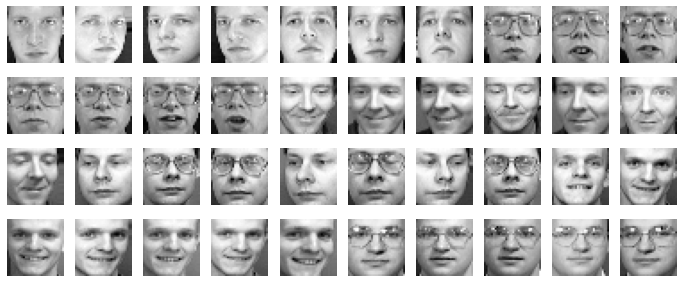

In [188]:
plt.figure(figsize=(12, 5))    
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(X[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')

Visualization in $2D$ space

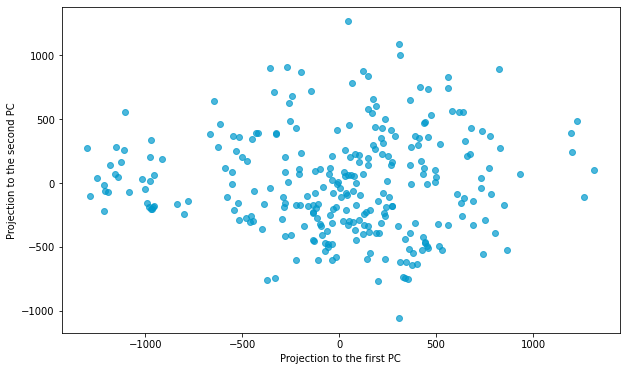

In [189]:
pca = PCA(n_components=2)
transform_X = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(transform_X[:, 0], transform_X[:, 1], 
            alpha=0.7, color='#0099CC')
plt.xlabel('Projection to the first PC')
plt.ylabel('Projection to the second PC')
plt.show()

Unexplained variance (доля необъясненной дисперсии)

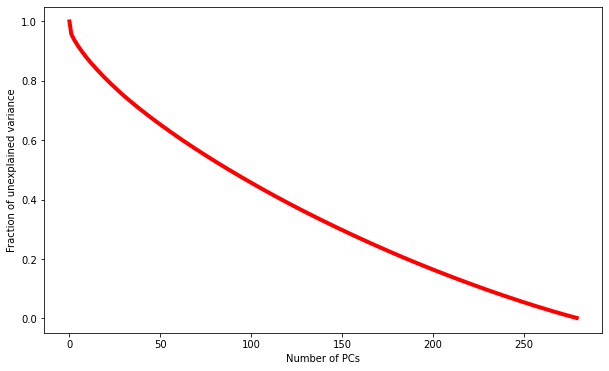

In [194]:
singular_values = np.sqrt(scipy.linalg.svdvals(X))
error = singular_values[::-1].cumsum() / singular_values.sum()
error = error[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, c='red', linewidth=4)
plt.xlabel('Number of PCs')
plt.ylabel('Fraction of unexplained variance')
plt.show()

Visualization of Principial Components

In [195]:
pca = PCA(n_components=50)
transform_X = pca.fit_transform(X)

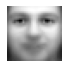

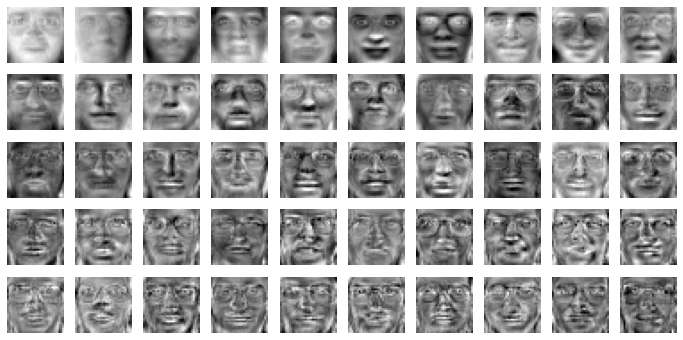

In [196]:
plt.figure(figsize=(1, 1))
plt.imshow(pca.mean_.reshape((32, 32)), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))    
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(pca.components_[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')

Data restoration based on the first Principial Components

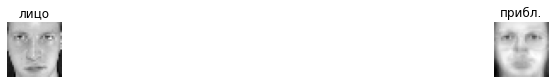

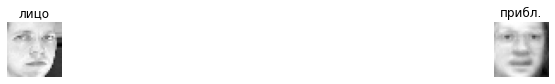

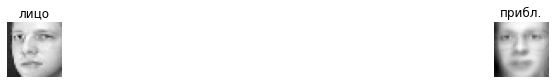

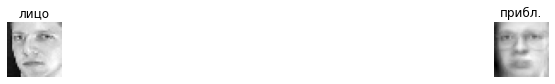

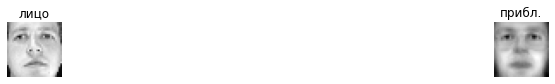

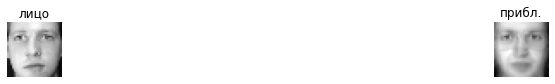

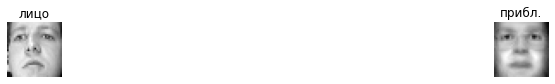

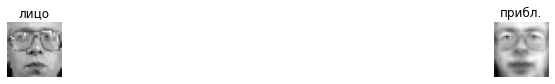

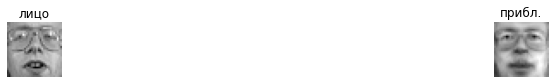

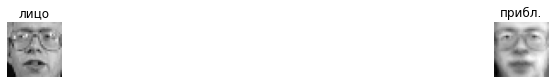

In [199]:
N_COMPONENTS = 10

pca = PCA(n_components=N_COMPONENTS)
transform_X = pca.fit_transform(X)

for i in range(10):
    X_hat = pca.inverse_transform(transform_X[i])
    plt.figure(figsize=(16, 1))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')
    plt.title('лицо')
    
    plt.subplot(1, 2, 2)
    plt.imshow(X_hat.reshape((32, 32)), cmap='gray')
    plt.axis('off')
    plt.title('прибл.')
        
    plt.show()

### Probabilistic PCA

<center><img src="pics/prob_pca.png" width=600 /></center>

$p(z) = N(z|0, I)$, $z \in \mathbb{R}^d$

$p(x|z) = N(x|Wz + \mu, \sigma^2 I)$, where $x, \mu \in \mathbb{R}^D$, $W \in \mathbb{R}^{D \times d}$

**Question.** 

$p(x) = ?$

$x = Wz + \mu + \varepsilon, \varepsilon \sim N(0, \sigma^2I)$

## Bayesian framework

**Task.**

Consider the task of an illness diagnosis. We have two tests: $\textbf{test 1}$ and $\textbf{test 2}$:

The tests are based on different mechanisms. 

$p\big(\{\textbf{test 1} = 1\} \big| \{\text{subject is healty}\}\big) = 0.2$

$p\big(\{\textbf{test 1} = 1\} \big| \{\text{subject is sick}\}\big) = 0.7$

$p\big(\{\textbf{test 2} = 1\} \big| \{\text{subject is healty}\}\big) = 0.05$

$p\big(\{\textbf{test 2} = 1\} \big| \{\text{subject is sick}\}\big) = 0.9$

$p\big(\{ \text{subject is sick} \}\big) = 0.001$


**Question:**

$p\big( \{ \text{subject is healthy} \} \big| \{ \textbf{test 1} = 1\} \big) = ?$ , 

$p\big( \{ \text{subject is healthy} \} \big| \{ \textbf{test 1} = 1\} \cap \{\textbf{test 2} = 1\} \big) = ?$

### Bayes' theorem

**Statistician's view**

1. *Discrete case:* $P(D_k | A) = \frac{P(A | D_k) P(D_k)}{\sum\limits_{n}^{\infty} P(A | D_n) P(D_n)}$, where $D_i \bigcap D_j = \emptyset$ and $P\left(\bigcup\limits_{n = 1}^{\infty} D_n\right) = 1$. 
    
    * $A$ is a test result
    
    * $P(D_k)$ is our prior knowledge about the disease 
    
    * $P(D_k | A)$ is our posterior knowledge about the disease (which takes into account the test result)


2. *Absolutely continuous case:* $p_{\xi|\nu}(x | y) = \frac{p_{\nu|\xi}(y | x) p_{\xi}(x)}{p_{\nu}(y)} = \frac{p_{\nu|\xi}(y | x) p_{\xi}(x)}{\int\limits_{\mathbb{R}^d} p_{\nu|\xi}(y | x) p_{\xi}(x) d x}$, where $\xi$ an $\nu$ are absolutely continuous random vectors



### Bayes's theorem

Let $X_1, \dots, X_n \sim p(x| z)$. $p(z)$ describes our prior knowledge of the parameters (or hidden variables), $z \in \mathcal{Z}$. 

$p(\theta | X_1, \dots, X_n) = \frac{p(\boldsymbol{X}_{1:n} | z) p(z)}{p(\boldsymbol{X}_{1:n})} = \frac{p(z) \prod\limits_{i = 1}^{n}p(X_i|\theta)}{\int\limits_{\mathcal{Z}}p(\theta) \prod\limits_{i = 1}^{n} p(X_i|z) d z}$